In [15]:
import sys
sys.path.insert(0,'..')

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import torch
import re

from src.model_functions import model_factory

from analysis_utils import get_sparsity_for_model, get_sparsity_info, get_viz_data, get_nonzero_dicts

from IPython.display import clear_output

In [17]:
output_folder = "charts"
model_type = "bertbase" # bertl4

folder = f"/share/home/lukash/pan16/{model_type}/cp_modular"
# experiment_name = "adverserial-diff_pruning_0.01-bert-base-uncased-64-2e-05-sp_pen1.25e-07-weighted_loss_prot-age-seed{}.pt"
# experiment_name = "adverserial-diff_pruning_0.01-bert-base-uncased-64-2e-05-sp_pen1.25e-07-cp_init-weighted_loss_prot-gender-seed{}.pt"
experiment_name = "modular-diff_pruning_0.01-bert-base-uncased-64-2e-05-sp_pen1.25e-07-weighted_loss_prot-gender_age-seed{}.pt"

# visualization params
model_cat = "modular" # adverserial, modular
prot_attr = "gender"
savefigs = False

In [18]:
# filepath = os.path.join(folder, experiment_name.format(0))
# model = model_factory(filepath)
# model_dict, model_module_dict, model_layer_dict = get_sparsity_for_model(model)

In [19]:
model_dicts, model_layer_dicts, model_module_dicts = get_sparsity_info(folder, experiment_name, par_idx=0)
clear_output()

In [20]:
base_dict, layer_dict, module_dict, emb_dict, layer_list = get_viz_data(model_dicts, model_layer_dicts, model_module_dicts)

In [21]:
n_layers = len(layer_list)
n_modules = len(layer_list[0])
module_names = list(layer_list[0].keys())

cmap = plt.get_cmap('Oranges')

# use to change number range for color gradient
color_fn = lambda x: x # abs(x-1)-0.2

width = 1
spacing = width / 4
y_coords = np.arange(n_layers)
y_coords_adj = np.concatenate([
    y_coords,
    [y_coords[-1] + width, y_coords[-1] + width*1.5]]
)
hline_positions = np.concatenate([
    (y_coords - width/2),
    [y_coords[-1] + width/2, y_coords_adj[-1] - width/2, y_coords_adj[-1] + width/2]
])
vline_positions = [0, width*n_modules, width*n_modules+spacing, width*(n_modules+1)+spacing]

ar_to_scalar = lambda ar: ar.flatten()[0]

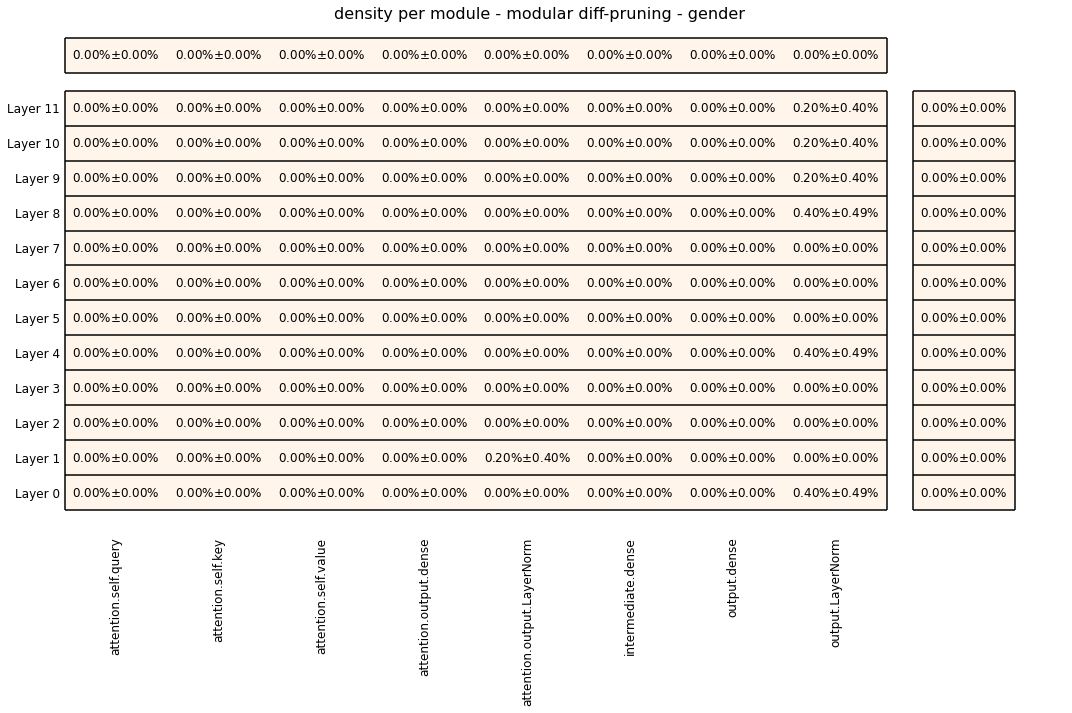

In [23]:
title_fontsize = 16
text_fontsize = 12
title = f"density per module - {model_cat} diff-pruning - {prot_attr}"
filename = f"density_per_module_{model_cat}_{prot_attr}.png"

plt.figure(figsize=(15,10))
plt.barh(y_coords_adj, width/2, left=0-width/2, height=width, color="w")
start = 0
for m_name in module_names:
    averages, error_margins = zip(*[l[m_name] for l in layer_list])
    m_average, m_error_margin = [ar_to_scalar(ar) for ar in module_dict[m_name]]
    color = [cmap(color_fn(a)) for a in averages]
    color.append("w")
    color.append(cmap(color_fn(m_average)))
    plt.barh(y_coords_adj, width, height=width, left=start, color=color)
    for y, a, e in zip(y_coords, averages, error_margins):
        a, e = ar_to_scalar(a), ar_to_scalar(e)
        plt.text(start+width/2, y, "{:.2%}$\pm${:.2%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)
    plt.text(start+width/2, y_coords_adj[-1], "{:.2%}$\pm${:.2%}".format(m_average, m_error_margin), ha='center', va='center', color="k", fontsize=text_fontsize)
    start += width

plt.barh(y_coords, spacing, left=start, height=width, color="w")
start += spacing

averages, error_margins = zip(*list(layer_dict.values())[1:])
color = [cmap(color_fn(a)) for a in averages]
plt.barh(y_coords, width, left=start, height=width, color=color)
for y, a, e in zip(y_coords, averages, error_margins):
    a, e = ar_to_scalar(a), ar_to_scalar(e)
    plt.text(start+width/2, y, "{:.2%}$\pm${:.2%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)

for y in hline_positions:
    plt.hlines(y, 0, width*n_modules, colors="black")
for y in hline_positions[:-2]:
    plt.hlines(y, width*n_modules+spacing, width*(n_modules+1)+spacing, colors="black")

for x in vline_positions:
    plt.vlines(x, 0-width/2, y_coords[-1]+width/2, colors="black")
for x in vline_positions[:2]:
    plt.vlines(x, y_coords_adj[-1]-width/2, y_coords_adj[-1]+width/2, colors="black")

plt.xticks(np.arange(n_modules, step=width) + width/2, labels=module_names, rotation=90, fontsize=text_fontsize)
plt.yticks(y_coords, labels=[f"Layer {i}" for i in range(n_layers)], fontsize=text_fontsize)
plt.title(title, fontsize=title_fontsize, y=.98)
sns.despine(left=True, bottom=True, right=True)
plt.tick_params(axis="x", bottom=False, pad=0)
plt.tick_params(axis="y", left=False, pad=-50)

plt.tight_layout()
if savefigs:
    plt.savefig(os.path.join(output_folder, filename))
plt.show()

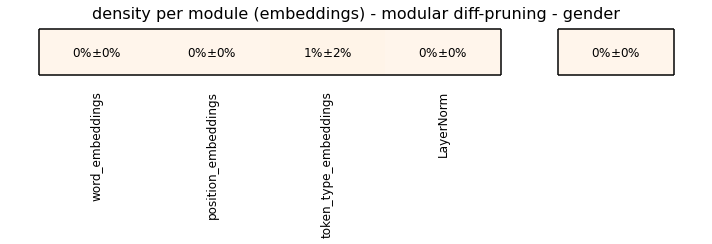

In [14]:
title = f"density per module (embeddings) - {model_cat} diff-pruning - {prot_attr}"
filename = f"density_per_module_embeddings_{model_cat}_{prot_attr}.png"

emb_dict = {k[11:]:v for k,v in base_dict.items() if k[:10]=="embeddings"}
n_modules = len(emb_dict)

width = 1
spacing = width / 4
x_coords = np.arange(n_modules, step=width)
x_coords_adj = np.concatenate([x_coords, [x_coords[-1]+spacing+width/2, x_coords[-1]+width*1.5]])
averages, error_margins= zip(*emb_dict.values())
l_average, l_error_margin = np.concatenate(layer_dict[0])
color = [cmap(color_fn(a)) for a in averages] + ["w", cmap(color_fn(l_average))]
plt.figure(figsize=(10,3.5))
plt.bar(x_coords_adj, height=width, width=[width] * n_modules + [spacing, width], color=color)
for x, a, e in zip(x_coords, averages, error_margins):
    a, e = ar_to_scalar(a), ar_to_scalar(e)
    plt.text(x, width/2, "{:.0%}$\pm${:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)
plt.text(x_coords_adj[-1], width/2, "{:.0%}$\pm${:.0%}".format(l_average, l_error_margin), ha='center', va='center', color="k", fontsize=text_fontsize)

x_coords_lines = [x_coords[0]-width/2, x_coords[-1]+width/2, x_coords[-1]+width/2+spacing*2, x_coords[-1]+width*1.5+spacing*2]
for y in [0, width]:
    plt.hlines(y, x_coords_lines[0], x_coords_lines[1], colors="black")
    plt.hlines(y, x_coords_lines[2], x_coords_lines[3], colors="black")
for x in x_coords_lines:
    plt.vlines(x, 0, width, colors="black")

plt.bar(0, height=-width, width=width, color="w")

plt.xticks(x_coords, labels=emb_dict.keys(), rotation=90, fontsize=text_fontsize)
plt.yticks([])
plt.title(title, fontsize=title_fontsize)
sns.despine(left=True, bottom=True, right=True)
plt.tick_params(axis="x", bottom=False, pad=-40)

plt.tight_layout()
if savefigs:
    plt.savefig(os.path.join(output_folder, filename))
plt.show()